![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir si el precio del automóvil es alto o no. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
import math

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

# Visualización dataset
data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
7,2014,6480,0,0,0,1,0,0,0,1
11,2014,39972,0,0,0,0,1,0,0,0
167,2016,18989,0,0,0,0,0,1,0,1
225,2014,51330,0,0,0,1,0,0,0,0
270,2007,116065,0,1,0,0,0,0,0,0


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el acurracy del modelo en el set de test.

In [8]:
# Celda 1

# Definición de la función que calcula el gini index

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)
    
# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k

def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del 
# árbol

def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10, min_samples=None):
    
    # Si solo es una observación
    
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Revisar el criterio de parada
    
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree
    
    # Continuar creando la partición
    
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    
    # Parar si la partición resultaría en un número de muestras inferior al mínimo
    
    if min_samples is not None:
        if X_l.shape[0] < min_samples or X_r.shape[0] < min_samples:
            return tree
    
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, 
                           min_samples=min_samples)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct, 
                           min_samples=min_samples)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Se entrena el árbol utilizando el subconjunto de entrenamiento

tree = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=10, num_pct=10, 
                 min_samples=int(X_train.shape[0]*0.01))

# Se muestra la estructura del arbol entrenado

print('Estructura del árbol:')
display(tree)

# Se calculan las predicciones utilizando el subconjunto de evaluación

tree_predictions = tree_predict(X_test, tree)

# Cálculo del accuracy

from sklearn.metrics import accuracy_score

print('Accuracy árbol de clasificación manual =', accuracy_score(tree_predictions, y_test))

Estructura del árbol:


{'y_pred': 1,
 'y_prob': 0.5778472913408218,
 'level': 0,
 'split': [1, 51394.909090909096],
 'n_samples': 7031,
 'gain': 0.23630504821132137,
 'sl': {'y_pred': 1,
  'y_prob': 0.8375781948168007,
  'level': 1,
  'split': [0, 2015.0],
  'n_samples': 4474,
  'gain': 0.03713896892744761,
  'sl': {'y_pred': 1,
   'y_prob': 0.6404416839199448,
   'level': 2,
   'split': [0, 2013.0],
   'n_samples': 1447,
   'gain': 0.043426293133466354,
   'sl': {'y_pred': 0,
    'y_prob': 0.2780487804878049,
    'level': 3,
    'split': [0, 2012.0],
    'n_samples': 203,
    'gain': 0.05394731382546758,
    'sl': {'y_pred': 0,
     'y_prob': 0.09195402298850575,
     'level': 4,
     'split': -1,
     'n_samples': 85,
     'gain': 0.01352946029496721},
    'sr': {'y_pred': 0,
     'y_prob': 0.4166666666666667,
     'level': 4,
     'split': -1,
     'n_samples': 118,
     'gain': 0.020017026523643233}},
   'sr': {'y_pred': 1,
    'y_prob': 0.6998394863563403,
    'level': 3,
    'split': [1, 39822.0],
    

Accuracy árbol de clasificación manual = 0.8836605080831409


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de clasificación y comenten sobre el desempeño del modelo.

In [9]:
# Celda 2

# Creación de 10 muestras de bootstrap

np.random.seed(1)

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

# Construcción un árbol de decisión para cada muestra boostrap

from sklearn.tree import DecisionTreeClassifier

# Definición del modelo usando DecisionTreeRegressor de sklearn

clf = DecisionTreeClassifier(max_depth=None, random_state=1)

# DataFrame para guardar las predicciones de cada árbol

y_pred_bag = pd.DataFrame(index=y_test.index, columns=[list(range(n_B))])

# Entrenamiento de un árbol sobre cada muestra boostrap y predicción sobre los datos de test

for i, sample in enumerate(samples):
    X_train_bootstrapped = X_train.iloc[sample, :]
    y_train_bootstrapped = y_train.iloc[sample]
    clf.fit(X_train_bootstrapped, y_train_bootstrapped)
    y_pred_bag.iloc[:,i] = clf.predict(X_test)
    
# Agregación de los árboles por votación mayoritaria

manual_bagging_predictions = np.where(np.mean(y_pred_bag, axis = 1) >= 0.5, 1, 0)

# Reporte del desempeño

print('Accuracy bagging manual =', accuracy_score(manual_bagging_predictions, y_test))
print("""
Comentarios sobre los resultados: Luego de entrenar el modelo bagging con 10 árboles de clasificación y observar el Accuracy
con un valor 0.85, encontramos que este valor es un poco menor al del arbol manual elaborado en el punto anterior.
Pese a esto, se puede decir que el modelo obtiene buenos resultados y podría servir para realizar la clasificación.

""")

Accuracy bagging manual = 0.8565242494226328

Comentarios sobre los resultados: Luego de entrenar el modelo bagging con 10 árboles de clasificación y observar el Accuracy
con un valor 0.85, encontramos que este valor es un poco menor al del arbol manual elaborado en el punto anterior.
Pese a esto, se puede decir que el modelo obtiene buenos resultados y podría servir para realizar la clasificación.




### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de clasificación y el parámetro `max_features` igual a `log(n_features)`. Presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [19]:
# Celda 3

# Definición del modelo bagging con sklearn

from sklearn.ensemble import BaggingClassifier

n_features = X.shape[1]

clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=10, max_features=int(math.log(n_features)), 
                        bootstrap=True, oob_score=True, random_state=1)

# Entrenamiento del modelo bagging con sklearn

clf.fit(X_train, y_train)

# Predicciones del modelo bagging con sklearn

bagging_predictions = clf.predict(X_test)

# Reporte del desempeño

print('Accuracy bagging con sklearn =', accuracy_score(bagging_predictions, y_test))
print("""
Comentarios sobre los resultados: Luego de entrenar el modelo bagging de scikitlearn, con 10 árboles de clasificación y 
un max_features=2 (resultado del logaritmo natural de (9 predictores)), el modelo nos entrega un Accuracy con un valor 0.849, 
se puede decir que el modelo obtiene buenos resultados y podría servir para realizar la clasificación.

El Accuracy obtenido es muy similar al Bagging manual realizado en el punto 2, pero un poco más bajo. Esto nos sugiere que 
limitar el número de parámetros a tener en cuenta para encontrar la mejor división no fue la mejor estrategia. De igual forma 
podríamos explorar el tunning de los parametros y obtener valores superiores del accuracy con bagging al modificar este parámetro. 

""")

Accuracy bagging con sklearn = 0.8493071593533488

Comentarios sobre los resultados: Luego de entrenar el modelo bagging de scikitlearn, con 10 árboles de clasificación y 
un max_features=2 (resultado del logaritmo natural de (9 predictores)), el modelo nos entrega un Accuracy con un valor 0.849, 
se puede decir que el modelo obtiene buenos resultados y podría servir para realizar la clasificación.

El Accuracy obtenido es muy similar al Bagging manual realizado en el punto 2, pero un poco más bajo. Esto nos sugiere que 
limitar el número de parámetros a tener en cuenta para encontrar la mejor división no fue la mejor estrategia. De igual forma 
podríamos explorar el tunning de los parametros y obtener valores superiores del accuracy con bagging al modificar este parámetro. 




### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para clasificación y presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [23]:
# Celda 4

# Definición del modelo random forest con sklearn

from sklearn.ensemble import RandomForestClassifier

n_features = X.shape[1]

clf = RandomForestClassifier()

# Entrenamiento del modelo random forest con sklearn

clf.fit(X_train, y_train)

# Predicciones del modelo random forest con sklearn

rf_predictions = clf.predict(X_test)

# Reporte del desempeño
Acc_RF=accuracy_score(rf_predictions, y_test)
print('Accuracy random forest con sklearn =', accuracy_score(rf_predictions, y_test))
print("""
Comentarios sobre los resultados: Luego de entrenar el modelo random forest de scikitlearn, se obtiene un Accuracy con un
valor 0.844,y se puede decir que el modelo obtiene buenos resultados y podría servir para realizar la clasificación.

Teniendo en cuenta que el clasificador se entrenó con los valores por defecto, es para destacar que se obtiene un accuracy
similar al bagging del anterior punto con scikitlearn. Esto también se esperaba, considerando que el parámetro por defecto de 
RandomForestClassifier para max_features es igual a sqrt(n_features)=3, similar al parámetro usado anteriormente.

""")

Accuracy random forest con sklearn = 0.8438221709006929

Comentarios sobre los resultados: Luego de entrenar el modelo random forest de scikitlearn, se obtiene un Accuracy con un
valor 0.844,y se puede decir que el modelo obtiene buenos resultados y podría servir para realizar la clasificación.

Teniendo en cuenta que el clasificador se entrenó con los valores por defecto, es para destacar que se obtiene un accuracy
similar al bagging del anterior punto con scikitlearn. Esto también se esperaba, considerando que el parámetro por defecto de 
RandomForestClassifier para max_features es igual a sqrt(n_features)=3, similar al parámetro usado anteriormente.




### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

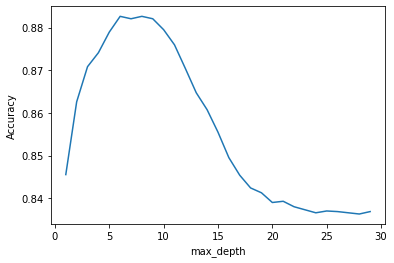

La calibración indica que el mejor desempeño se obtiene con una profundidad de 6 (max_depth=6) 


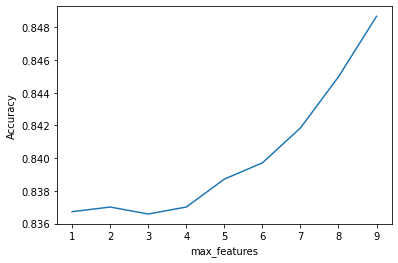

La calibración indica que el mejor desempeño se obtiene con el mayor numero de variables disponible. 
      Se elige (max_features=9)


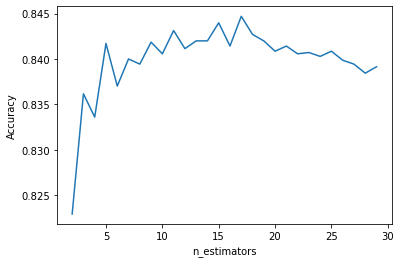

La calibración indica que el mejor desempeño se obtiene con 17 arboles (n_estimators=17) 
Accuracy random forest con sklearn = 0.8882794457274826

Comentarios:

Para realizar la calibración se realizaron varias iteraciones ajustando cada vez, el rango de valores que se querían probar, 
llegando finalmente a tener un ajuste fino. Esto se realizó con cada uno de los tres parámetros por separado.

Luego se pasan estos tres parámetros al modelo para entrenarlo y realizar la predicción.

Se observa que luego de haber calibrado los tres parámetros max_depth, max_features y n_estimators, el accuracy incrementó 
desde 0.844 a 0.888, lo cual es una mejora significativa, lo que reafirma que un modelo como RF calibrado tiene un buen desempeño.



In [24]:
# Celda 5

from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

def cal_max_depth(inicial, final, paso): 
    # Creación de lista de valores para iterar sobre diferentes valores de n_estimators
    estimator_range = range(inicial,final, paso)

    # Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
    accuracy_scores = []

    # Uso de un 15-fold cross-validation para cada valor de n_estimators
    for estimator in estimator_range:
        clf = RandomForestClassifier(max_depth=estimator, random_state=1, n_jobs=-1)
        accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=15, scoring='accuracy').mean())

    # Gráfica del desempeño del modelo vs la cantidad de n_estimators
    plt.plot(estimator_range, accuracy_scores)
    plt.xlabel('max_depth')
    plt.ylabel('Accuracy')
    plt.show()
    return
cal_max_depth(1, 30, 1)
print("La calibración indica que el mejor desempeño se obtiene con una profundidad de 6 (max_depth=6) ")

def cal_n_features(n_features):
    # Creación de lista de valores para iterar sobre diferentes valores de max_features
    feature_range = range(1, n_features+1)

    # Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de max_features
    accuracy_scores = []

    # Uso de un 15-fold cross-validation para cada valor de max_features
    for feature in feature_range:
        clf = RandomForestClassifier(max_features=feature, random_state=1, n_jobs=-1)
        accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=15, scoring='accuracy').mean())

    plt.plot(feature_range, accuracy_scores)
    plt.xlabel('max_features')
    plt.ylabel('Accuracy')
    plt.show()
    return
cal_n_features(n_features)
print("""La calibración indica que el mejor desempeño se obtiene con el mayor numero de variables disponible. 
      Se elige (max_features=9)""")

def cal_n_estimators(inicial, final, paso): 
    # Creación de lista de valores para iterar sobre diferentes valores de n_estimators
    estimator_range = range(inicial,final, paso)

    # Definición de lista para almacenar la exactitud (accuracy) promedio para cada valor de n_estimators
    accuracy_scores = []

    # Uso de un 15-fold cross-validation para cada valor de n_estimators
    for estimator in estimator_range:
        clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
        accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=15, scoring='accuracy').mean())

    # Gráfica del desempeño del modelo vs la cantidad de n_estimators
    plt.plot(estimator_range, accuracy_scores)
    plt.xlabel('n_estimators')
    plt.ylabel('Accuracy')
    plt.show()
    return
cal_n_estimators(2, 30, 1)

print("La calibración indica que el mejor desempeño se obtiene con 17 arboles (n_estimators=17) ")

#Modelo con parametros calibrados
clf = RandomForestClassifier(max_depth=6, max_features=9, n_estimators=17,random_state=1, n_jobs=-1)

# Entrenamiento del modelo random forest con sklearn

clf.fit(X_train, y_train)

# Predicciones del modelo random forest con sklearn

rf_predictions = clf.predict(X_test)

# Reporte del desempeño
Acc_RF_Cal=accuracy_score(rf_predictions, y_test)
print('Accuracy random forest con sklearn =', accuracy_score(rf_predictions, y_test))

print("""
Comentarios:

Para realizar la calibración se realizaron varias iteraciones ajustando cada vez, el rango de valores que se querían probar, 
llegando finalmente a tener un ajuste fino. Esto se realizó con cada uno de los tres parámetros por separado.

Luego se pasan estos tres parámetros al modelo para entrenarlo y realizar la predicción.

Se observa que luego de haber calibrado los tres parámetros max_depth, max_features y n_estimators, el accuracy incrementó 
desde 0.844 a 0.888, lo cual es una mejora significativa, lo que reafirma que un modelo como RF calibrado tiene un mejor desempeño.
""")

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de clasificación con la librería sklearn, presenten el acurracy del modelo en el set de test y comenten sus resultados.

In [27]:
# Celda 6
from xgboost import XGBClassifier
from sklearn import metrics
clf = XGBClassifier()
clf
clf.fit(X_train, y_train,eval_metric='logloss')
y_pred = clf.predict(X_test)
print(" \nF1 Score :" +str(metrics.f1_score(y_pred, y_test.values)))
Acc_XGB=metrics.accuracy_score(y_pred, y_test.values)
print("Accuracy Score: " +str(metrics.accuracy_score(y_pred, y_test.values)))
print("""\nLuego de entrenar el modelo Xtreme gradient Boosting se obtiene un accuracy de 0.885 que es similar al obtenido con 
RF calibrado, lo que nos da un indicio sobre la potencia del XGboosting. Este valor nos demuestra un buen desempeño del modelo.""")

 
F1 Score :0.9047160731472569
Accuracy Score: 0.8856812933025404

Luego de entrenar el modelo Xtreme gradient Boosting se obtiene un accuracy de 0.885 que es similar al obtenido con 
RF calibrado, lo que nos da un indicio sobre la potencia del XGboosting. Este valor nos demuestra un buen desempeño del modelo.


### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para clasificación. Presenten el acurracy del modelo en el set de test, comenten sus resultados y análicen cómo cada parámetro afecta el modelo.

In [30]:
# Celda 7

from sklearn.model_selection import RandomizedSearchCV
params = {
 "learning_rate" : [0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.10,0.15,0.25],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4,0.45,0.5,0.6 ],
 "colsample_bytree" : [ 0.2,0.25,0.3,0.35, 0.4, 0.5 , 0.7 ]
}
clf_tun = XGBClassifier()
tun_XGB=RandomizedSearchCV(clf_tun,param_distributions=params,n_iter=15,scoring='roc_auc',n_jobs=-1,cv=5,verbose=2)
tun_XGB.fit(X_train, y_train,eval_metric='logloss')
display(tun_XGB.best_estimator_)

best_XGB=tun_XGB.best_estimator_

y_pred = best_XGB.predict(X_test)
print(" \nF1 Score :" +str(metrics.f1_score(y_pred, y_test.values)))
Acc_XGB_cal=metrics.accuracy_score(y_pred, y_test.values)
print("Accuracy Score: " +str(metrics.accuracy_score(y_pred, y_test.values)))

print("""
Comentarios:

Para realizar la calibración se utilizó el método RandomizedSearchCV, en donde se realizaron varias iteraciones ajustando 
cada vez, el rango de valores que se querían probar, llegando finalmente a tener un ajuste fino. Esto se realizó con cada
los tres parámetros al tiempo, en cada iteración. 

Luego se pasan estos tres parámetros al modelo para entrenarlo y realizar la predicción.

Se observa que luego de haber calibrado los tres parámetros max_depth, max_features y n_estimators, el accuracy incrementó 
desde 0.885 a 0.888, lo cual es una mejora poco significativa, lo que indica que se puede seguir explorando con otros parametros
para encontrar una calibración con mejores resultados. El modelo XGB calibrado tiene un buen desempeño.
""")


Fitting 5 folds for each of 15 candidates, totalling 75 fits


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.35,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.07, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

 
F1 Score :0.9066222010481182
Accuracy Score: 0.8868360277136259

Comentarios:

Para realizar la calibración se utilizó el método RandomizedSearchCV, en donde se realizaron varias iteraciones ajustando 
cada vez, el rango de valores que se querían probar, llegando finalmente a tener un ajuste fino. Esto se realizó con cada
los tres parámetros al tiempo, en cada iteración. 

Luego se pasan estos tres parámetros al modelo para entrenarlo y realizar la predicción.

Se observa que luego de haber calibrado los tres parámetros max_depth, max_features y n_estimators, el accuracy incrementó 
desde 0.885 a 0.888, lo cual es una mejora poco significativa, lo que indica que se puede seguir explorando con otros parametros
para encontrar una calibración con mejores resultados. El modelo XGB calibrado tiene un buen desempeño.



### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

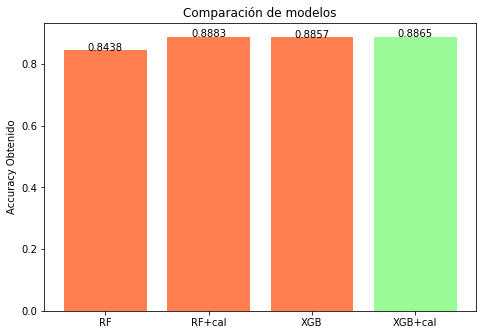


Comentarios:

En la gráfica se comparan los valores obtenidos del Accuracy para cada modelo. De izquierda a derecha tenemos: 
Random Forest sin calibrar con 0.8441, Random Forest calibrado con 0.8883, Extreme Gradient Boosting sin calibrar 
con 0.8857 y finalmente, el modelo con mejor desempeño resaltado en color verde, el Extreme Gradient Boosting calibrado con
0.8877.

Estos valores fueron obtenidos haciendo las predicciones en Xtest y comparándolo con los datos de YTest.

El modelo con el mejor desempeño fue XGB calibrado y el de menor desempeño fue Random Forest sin calibrar.
El XGB calibrado tiene como ventaja que es más rápido al momento de entrenar y que obtiene una mejor tasa de éxito.
El RF sin calibrar tiene como desventaja que tiene menor poder predictivo.



In [29]:
# Celda 8

Acc_RF
Acc_RF_Cal
Acc_XGB
Acc_XGB_cal

#Comparacion de modelos 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de modelos")
ejeX = ['RF','RF+cal','XGB','XGB+cal']
ejeY = [round(Acc_RF,4), round(Acc_RF_Cal,4), round(Acc_XGB,4), round(Acc_XGB_cal,4)]     
ax.bar(ejeX,ejeY,color=['Coral','Coral','Coral','PaleGreen'])    #color='Coral'
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i],ha='center')
addlabels(ejeX,ejeY,plt)
plt.ylabel("Accuracy Obtenido")
plt.show()

print("""
Comentarios:

En la gráfica se comparan los valores obtenidos del Accuracy para cada modelo. De izquierda a derecha tenemos: 
Random Forest sin calibrar con 0.8441, Random Forest calibrado con 0.8883, Extreme Gradient Boosting sin calibrar 
con 0.8857 y finalmente, el modelo con mejor desempeño resaltado en color verde, el Extreme Gradient Boosting calibrado con
0.8877.

Estos valores fueron obtenidos haciendo las predicciones en Xtest y comparándolo con los datos de YTest.

El modelo con el mejor desempeño fue XGB calibrado y el de menor desempeño fue Random Forest sin calibrar.
El XGB calibrado tiene como ventaja que es más rápido al momento de entrenar y que obtiene una mejor tasa de éxito.
El RF sin calibrar tiene como desventaja que tiene menor poder predictivo.
""")